#### *Applied Mathematical Finance 2*

#### *Makhova Anastasia*

## <ins> *Lab 3: Vanilla commodities* </ins>

The deadline is 23:59 on 25th of May, 2025. The solution must be sent up to the deadline on amf2-2025-spring@yandex.ru.


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

### 1. Composite coal swap (50 points)

You are given a composite coal swap with

* 12 observation dates $t_i$ equal to the last Friday of each calendar month of the year 2023.

* $S$ corresponding to weekly coal fixing.

* $X$ equal to the USDRUB fixing. 

* Payoff at $t_{12}$ is 

$$\frac{1}{12} \sum_{i=1}^{12} S_{t_i} X_{t_i + l} - K,$$

with $l=-2$ weeks being the FX fixing lag and $K$ the strike of the swap contract. 


Also assume that 

* The value date $t_0$ is `03/01/2023`;

* The continuously-compounded foreign-domestic rates difference $r_{\text{USD}} - r_{\text{RUB}} = 10\%$;

* The USDRUB spot and volatility equal to $100$ and $40\%$;

* The coal volatility is $50\%$ and the Coal/FX correlation is $-80\%$;

* The coal monthly average futures quotes (denominated in USD currency) are given in `lab3.csv`.

In [2]:
from datetime import datetime

t0 = datetime.strptime("03/01/2023", "%d/%m/%Y")

In [3]:
rate_diff = 0.1
FX_spot = 100
sigma_S = 0.5
sigma_X = 0.4
rho = -0.8

In [4]:
df = pd.read_csv("lab3.csv", sep=";")

df["Price"] = df["Price"].str.replace(",", ".").astype(float)
F = df["Price"].values 

# Переведем строки в даты
df["Expiry"] = pd.to_datetime(df["Futures Expiry Date"], format="%d/%m/%Y")

Finally, assume that the day count convention is `Act365`. 

In [5]:
df["tau"] = (df["Expiry"] - t0).dt.days / 365
tau_array = df["tau"].values


In [6]:
df.head()

,Unnamed: 0,Futures Expiry Date,Price,Expiry,tau
0,1,27/1/2023,230.00,2023-01-27,0.065753
1,2,24/2/2023,206.00,2023-02-24,0.142466
2,3,31/3/2023,194.90,2023-03-31,0.238356
3,4,28/4/2023,185.75,2023-04-28,0.315068
4,5,26/5/2023,174.50,2023-05-26,0.391781


#### 1.1 Curve stripping (25 points)

Build weekly-observable forward curve. 

In [7]:
# список всех пятниц в 2023
all_fridays = pd.date_range("2023-01-01", "2023-12-31", freq="W-FRI")
n = []

for month in range(1, 13):
    fridays_in_month = all_fridays[all_fridays.month == month]
    n.append(len(fridays_in_month))

n = np.array(n)
n

array([4, 4, 5, 4, 4, 5, 4, 4, 5, 4, 4, 5])

In [8]:
N_node = np.zeros(13)
for i in range(1, 13):
    N_node[i] = N_node[i-1] + n[i-1]

In [9]:
summation_curve_node = np.zeros(13)
for i in range(1, 13):
    summation_curve_node[i] = summation_curve_node[i-1] + F[i-1] * n[i-1]

In [10]:
from scipy.interpolate import PchipInterpolator

In [11]:
f_t = np.zeros(52)
N = np.arange(1,53)
for i in range(1,53):
  f_t[i-1] = PchipInterpolator(N_node, summation_curve_node)(i) - PchipInterpolator(N_node, summation_curve_node)(i-1)

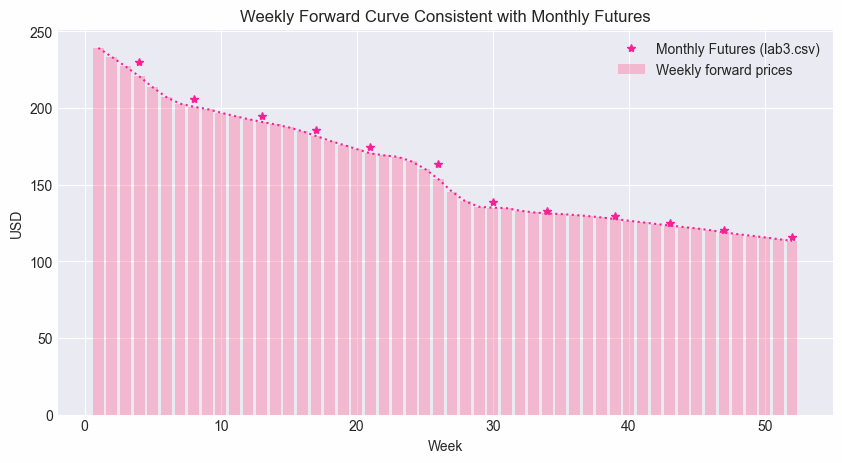

In [12]:
plt.figure(figsize=(10,5))

plt.plot(N_node[1:], F, '*', color='C2', label='Monthly Futures (lab3.csv)')
plt.plot(N, f_t,':', color='C2')
plt.bar(N, f_t, label='Weekly forward prices', alpha=0.4,  color='C1')
plt.xlabel("Week")
plt.ylabel("USD")
plt.title("Weekly Forward Curve Consistent with Monthly Futures")
plt.legend()
plt.grid(True)
plt.show()

#### 1.2 Composite coal swap pricing (25 points)

Using standard model of correlated Brownian motions compute par strike $K$ of a composite coal swap with the specifications provided above. 

In [ ]:
lag_days = -14 
lag_years = abs(lag_days) / 365

$$
\mathbb{E}^{Q^{FOR}}_t \left[F(t_i, θ(t_i + \tau))\dfrac{X(t_i + l)}{X(T)}\right] = F(t, θ(t_i + \tau))\dfrac{X(t, t_i + l)}{X(t, T)} ~ e^{-\rho \sigma_x \sigma_F~(-l)_+}.
$$

$$
\mathbb{E}^{Q^{DOM}}_t [F(t_i, θ(t_i + \tau))X(t_i + l)] = X(t, T) ~ \mathbb{E}^{Q^{FOR}}_t \left[F(t_i, θ(t_i + \tau))\dfrac{X(t_i + l)}{X(T)}\right]
$$

Thus,
$$
\mathbb{E}^{Q^{DOM}}_t [F(t_i, θ(t_i + \tau))X(t_i + l)] =  F(t, θ(t_i + \tau))X(t, t_i + l) ~ e^{-\rho \sigma_x \sigma_F~(-l)_+}
$$
and 
$$
K = \frac{1}{12} \sum_{i = 1}^{12} F(t, θ(t_i + \tau))X(t, t_i + l) ~ e^{-\rho \sigma_x \sigma_F~(-l)_+}
$$

In [14]:
quanto_adj = np.exp(-rho * sigma_S * sigma_X * lag_years)

In [15]:
from datetime import timedelta

In [ ]:
strike_terms = []

for ti in df["Expiry"]:
    t_fx = ti + timedelta(days=lag_days)
    tau_fx = (t_fx - t0).days / 365
    f_x = FX_spot * np.exp(rate_diff * tau_fx)

    week_index = (ti - t0).days // 7
    f_s = f_t[week_index]

    strike_terms.append(f_s * f_x * quanto_adj)


K = np.mean(strike_terms)
print(f"Par strike K = {K:.2f} RUB")

Par strike K = 16334.63 RUB


### 2. Brent vanilla option with early expiry (50 points)

You are given a European call option on BRENT_MAY_24 oil futures with expiry date `28/07/2023` and the strike $K = 70.73$. 

Assume that 

* The value date $t_0$ is `18/05/2023`;

* The BRENT_MAT_24 futures contract price is $70.73$ (that is, the option is ATM);

* The market implied volatility is $41.61\%$ and the natural option maturity is `25/03/2024`; 

* The futures contract maturity is `28/03/2024`;

* The Andersen's model parameters are $\sigma_0 = 0.5$, $\sigma_{\infty} = 0.2$, $\rho_{\infty} = 0.75$, $\kappa = 1$. Also assume that there is no seasonality in correlations, i.e. $f_{\infty}(t) = \rho_{\infty}$.

Using the Andersen's model, find the (undiscounted) price of a Europan call described above.

In [17]:
from scipy.stats import norm
from scipy.optimize import fsolve

In [18]:
t0 = datetime.strptime("18/05/2023", "%d/%m/%Y")
T1 = datetime.strptime("28/07/2023", "%d/%m/%Y")    # Option expiry
T_nat = datetime.strptime("25/03/2024", "%d/%m/%Y") # Natural expiry
T2 = datetime.strptime("28/03/2024", "%d/%m/%Y")    # Futures expiry

In [19]:
sigma_0 = 0.5
sigma_inf = 0.2
rho_inf = 0.75
f_inf = 0.75
kappa = 1.0

F0 = 70.73
K = 70.73

iv_nat = 0.4161  # Implied vol for natural expiry

$h_{\infty}, h_1, h_2$ via $\sigma_0, \sigma_{inf}, \rho_{inf}$

In [20]:
h_inf = sigma_inf
h1 = rho_inf * sigma_0 - h_inf
h2_squared = sigma_0**2 - (h1 + h_inf)**2
h2 = np.sqrt(h2_squared)

$d(\cdot)$

In [21]:
def f_inf_equation(d):
    q = h1 * h_inf / (h1**2 + h2**2)
    w = q * h_inf / h1

    lhs = (q * np.exp(d) + w)
    rhs = np.sqrt(w) * np.sqrt(np.exp(2 * d) + 2 * q * np.exp(d) + w)

    return lhs / rhs - f_inf

d = fsolve(f_inf_equation, 0.05)[0]

$a(\cdot)$ at Natural expiry 

In [22]:
def compute_a(iv, d, t, T1, T2):
    tau_nat = (T1 - t).days / 365
    T2_minus_T1 = (T2 - T1).days / 365
    T2_minus_t = (T2 - t).days / 365

    term1 = (h1**2 + h2**2) * np.exp(2 * d) * (np.exp(-2 * kappa * T2_minus_T1) - np.exp(-2 * kappa * T2_minus_t)) / (2* kappa * tau_nat)
    term2 = 2 * h1 * h_inf * np.exp(d) * (np.exp(-kappa * T2_minus_T1) - np.exp(-kappa * T2_minus_t)) / (2*kappa * tau_nat)
    total = term1 + term2 + h_inf**2

    return 0.5 * np.log(iv**2 / total)

a = compute_a(iv_nat, d, t0, T_nat, T2)

$\sigma_{term}(\cdot)$ at futures expiry

In [23]:
T1_minus_t = (T1 - t0).days / 365
T2_minus_T1 = (T2 - T1).days / 365
T2_minus_t = (T2 - t0).days / 365

In [24]:
term1 = (h1**2 + h2**2) * np.exp(2 * d) * (np.exp(-2 * kappa * T2_minus_T1) - np.exp(-2 * kappa * T2_minus_t)) / (2 * kappa * T1_minus_t)
term2 = 2 * h1 * h_inf * np.exp(d) * (np.exp(-kappa * T2_minus_T1) - np.exp(-kappa * T2_minus_t)) / (2 * kappa * T1_minus_t)
term3 = h_inf**2

sigma_term_squared = np.exp(2 * a) * (term1 + term2 + term3)
sigma_term = np.sqrt(sigma_term_squared)

Option price

In [25]:
d1 = (np.log(F0 / K) + 0.5 * sigma_term**2 * T1_minus_t) / (sigma_term * np.sqrt(T1_minus_t))
d2 = d1 - sigma_term * np.sqrt(T1_minus_t)
call_price = F0 * norm.cdf(d1) - K * norm.cdf(d2)

In [26]:
print(f"Calibrated d: {d:.4f}")
print(f"Calibrated a: {a:.4f}")
print(f"Model-implied term volatility (T1 = 28.07.23): {sigma_term:.4%}")
print(f"Undiscounted European call price: {call_price:.4f}")

Calibrated d: -0.0000
Calibrated a: 0.1459
Model-implied term volatility (T1 = 28.07.23): 34.0826%
Undiscounted European call price: 4.2376
